In [8]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import warnings

warnings.filterwarnings("ignore")

# === Загрузка и предобработка файла SBER ===
sber_raw = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sber_candles.csv")
sber = sber_raw[["begin", "close"]].copy()
sber["Date"] = pd.to_datetime(sber["begin"]).dt.date
sber = sber.rename(columns={"close": "Stock Close"}).drop(columns=["begin"])
sber = sber.groupby("Date").first().reset_index()
sber["Date"] = pd.to_datetime(sber["Date"])
sber.set_index("Date", inplace=True)

# === Функции ===
def load_and_prepare(file_path, date_col, value_col, skip_rows=0, date_format=None):
    df = pd.read_csv(file_path, skiprows=skip_rows)
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[[value_col]]

def process_non_standard_file(file_path, date_col, value_col):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = [date_col, value_col, 'High', 'Low', 'Open', 'Volume']
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[[value_col]]

def process_vix_file(file_path):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df.set_index('Date', inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[['Close']].rename(columns={'Close': 'VIX'})

# === Пути к данным ===
file_paths = {
    "imoex": "C:/Users/Matvey/Desktop/Диплом/imoex_candles.csv",
    "rtsi": "C:/Users/Matvey/Desktop/Диплом/rtsi_candles.csv",
    "vix": "C:/Users/Matvey/Desktop/Диплом/vix_data.csv",
    "gvz": "C:/Users/Matvey/Desktop/Диплом/gvz_data.csv",
    "gold": "C:/Users/Matvey/Desktop/Диплом/gold_data.csv",
    "oil": "C:/Users/Matvey/Desktop/Диплом/oil_data.csv",
    "moexog": "C:/Users/Matvey/Desktop/Диплом/moexog_candles.csv",
    "rgbi": "C:/Users/Matvey/Desktop/Диплом/rgbi_candles.csv",
    "macro": "C:/Users/Matvey/Desktop/Диплом/macroeconomic_data.csv"
}

# === Загрузка экзогенных переменных ===
imoex = load_and_prepare(file_paths["imoex"], "begin", "close").rename(columns={"close": "IMOEX Close"})
rtsi = load_and_prepare(file_paths["rtsi"], "begin", "close").rename(columns={"close": "RTSI Close"})
moexog = load_and_prepare(file_paths["moexog"], "begin", "close").rename(columns={"close": "MOEXOG Close"})
rgbi = load_and_prepare(file_paths["rgbi"], "begin", "close").rename(columns={"close": "RGBI Close"})
vix = process_vix_file(file_paths["vix"])
gvz = process_non_standard_file(file_paths["gvz"], "Date", "Close").rename(columns={"Close": "GVZ"})
gold = process_non_standard_file(file_paths["gold"], "Date", "Close").rename(columns={"Close": "Gold Price"})
oil = process_non_standard_file(file_paths["oil"], "Date", "Close").rename(columns={"Close": "Oil Price"})

# === Макроэкономика ===
macro_df = pd.read_csv(file_paths["macro"])
macro_df['date'] = pd.to_datetime(macro_df['date'], errors='coerce')
macro_df = macro_df.dropna(subset=['date'])
macro_df.set_index('date', inplace=True)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')]
macro_df = macro_df[['inflation', 'key_rate', 'usd_rate', 'cny_rate']]
macro_df.columns = ['Inflation', 'Key Rate', 'USD Rate', 'CNY Rate']
macro_df = macro_df.resample('D').interpolate()

# === Объединение всех данных ===
merged_data = pd.concat(
    [sber, imoex, rtsi, moexog, rgbi, vix, gvz, gold, oil, macro_df],
    axis=1
)

# === Заполнение пропусков ===
merged_data = merged_data.interpolate(method='linear')
merged_data = merged_data[::-1].ffill()[::-1]

# === Сброс индекса и сохранение с колонкой "Date" ===
merged_data = merged_data.reset_index().rename(columns={"index": "Date"})
output_path = "C:/Users/Matvey/Desktop/Диплом/sber_merged_data.csv"
merged_data.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"✅ Данные успешно сохранены в: {output_path}")
# Просмотр первых строк
display(merged_data.head())

✅ Данные успешно сохранены в: C:/Users/Matvey/Desktop/Диплом/sber_merged_data.csv


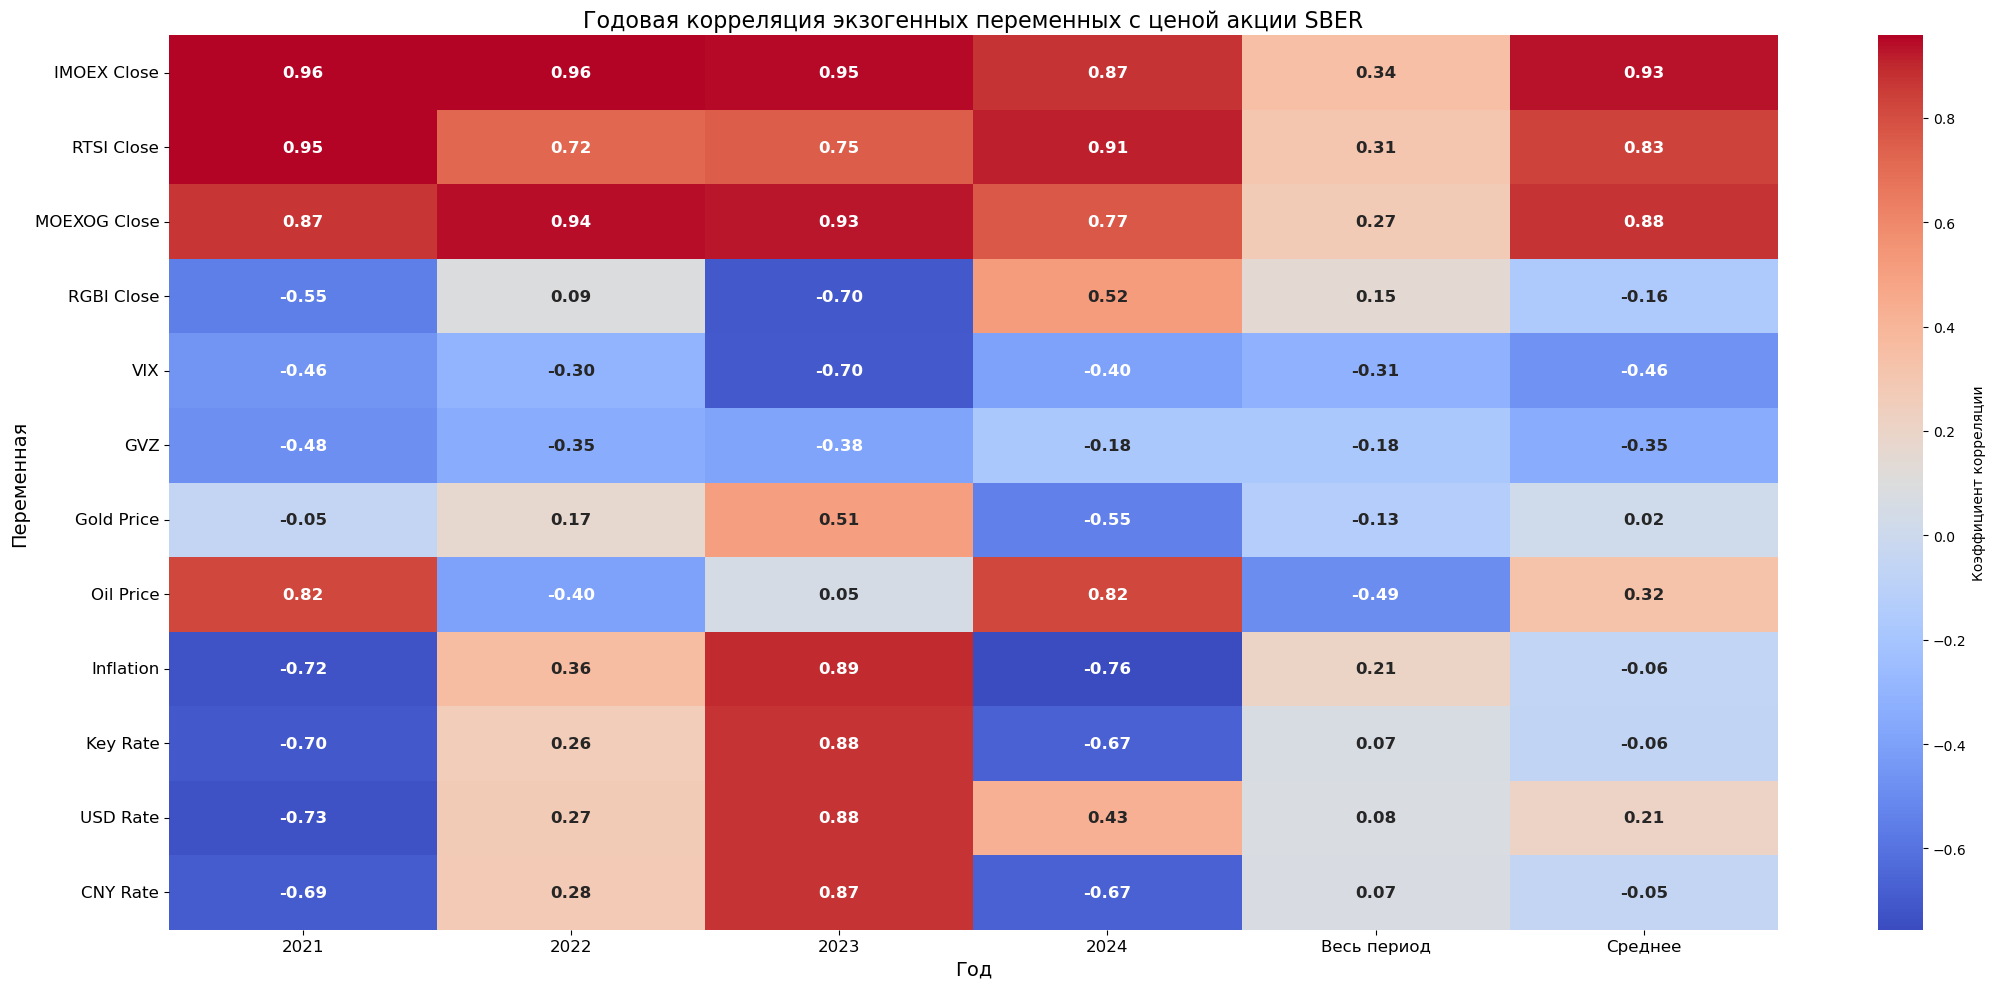

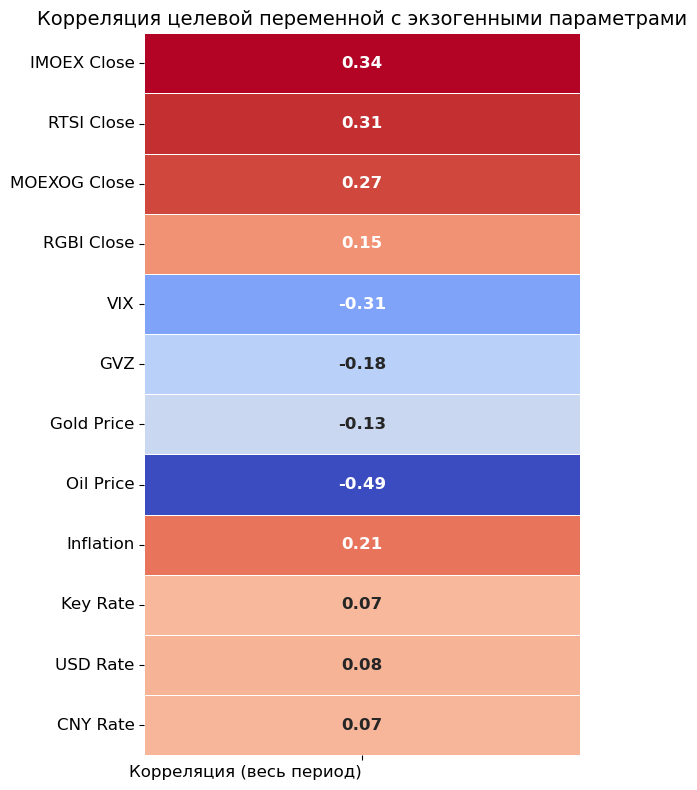

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Загрузка объединённых данных ===
merged_data = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sber_merged_data.csv")
merged_data["Date"] = pd.to_datetime(merged_data["Date"])
merged_data.set_index("Date", inplace=True)

# --- Годовые корреляции ---
years = range(2021, 2025)
yearly_corrs = {}

for year in years:
    yearly_df = merged_data[merged_data.index.year == year]
    if not yearly_df.empty:
        corr = yearly_df.corr(numeric_only=True)
        yearly_corrs[str(year)] = corr["Stock Close"].drop("Stock Close", errors="ignore")

# Корреляции за весь период
corr_all_period = merged_data.corr(numeric_only=True)["Stock Close"].drop("Stock Close", errors="ignore")
yearly_corrs["Весь период"] = corr_all_period

# Сводная таблица
corr_by_year_df = pd.DataFrame(yearly_corrs)
years_only = [str(year) for year in years if str(year) in corr_by_year_df.columns]
corr_by_year_df["Среднее"] = corr_by_year_df[years_only].mean(axis=1)

# --- Визуализация ---
plt.figure(figsize=(22, 10))
sns.heatmap(
    corr_by_year_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={'label': 'Коэффициент корреляции'},
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title("Годовая корреляция экзогенных переменных с ценой акции SBER", fontsize=16)
plt.xlabel("Год", fontsize=14)
plt.ylabel("Переменная", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# --- Корреляции за весь период (отдельно) ---
merged_data.reset_index(inplace=True)
data_for_corr = merged_data.drop(columns=["Date"], errors="ignore")
corr_all_period = data_for_corr.corr()["Stock Close"].drop("Stock Close", errors="ignore")

corr_df = pd.DataFrame(corr_all_period)
corr_df.columns = ["Корреляция (весь период)"]

plt.figure(figsize=(6, 8))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title("Корреляция целевой переменной с экзогенными параметрами", fontsize=14)
plt.xticks(fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


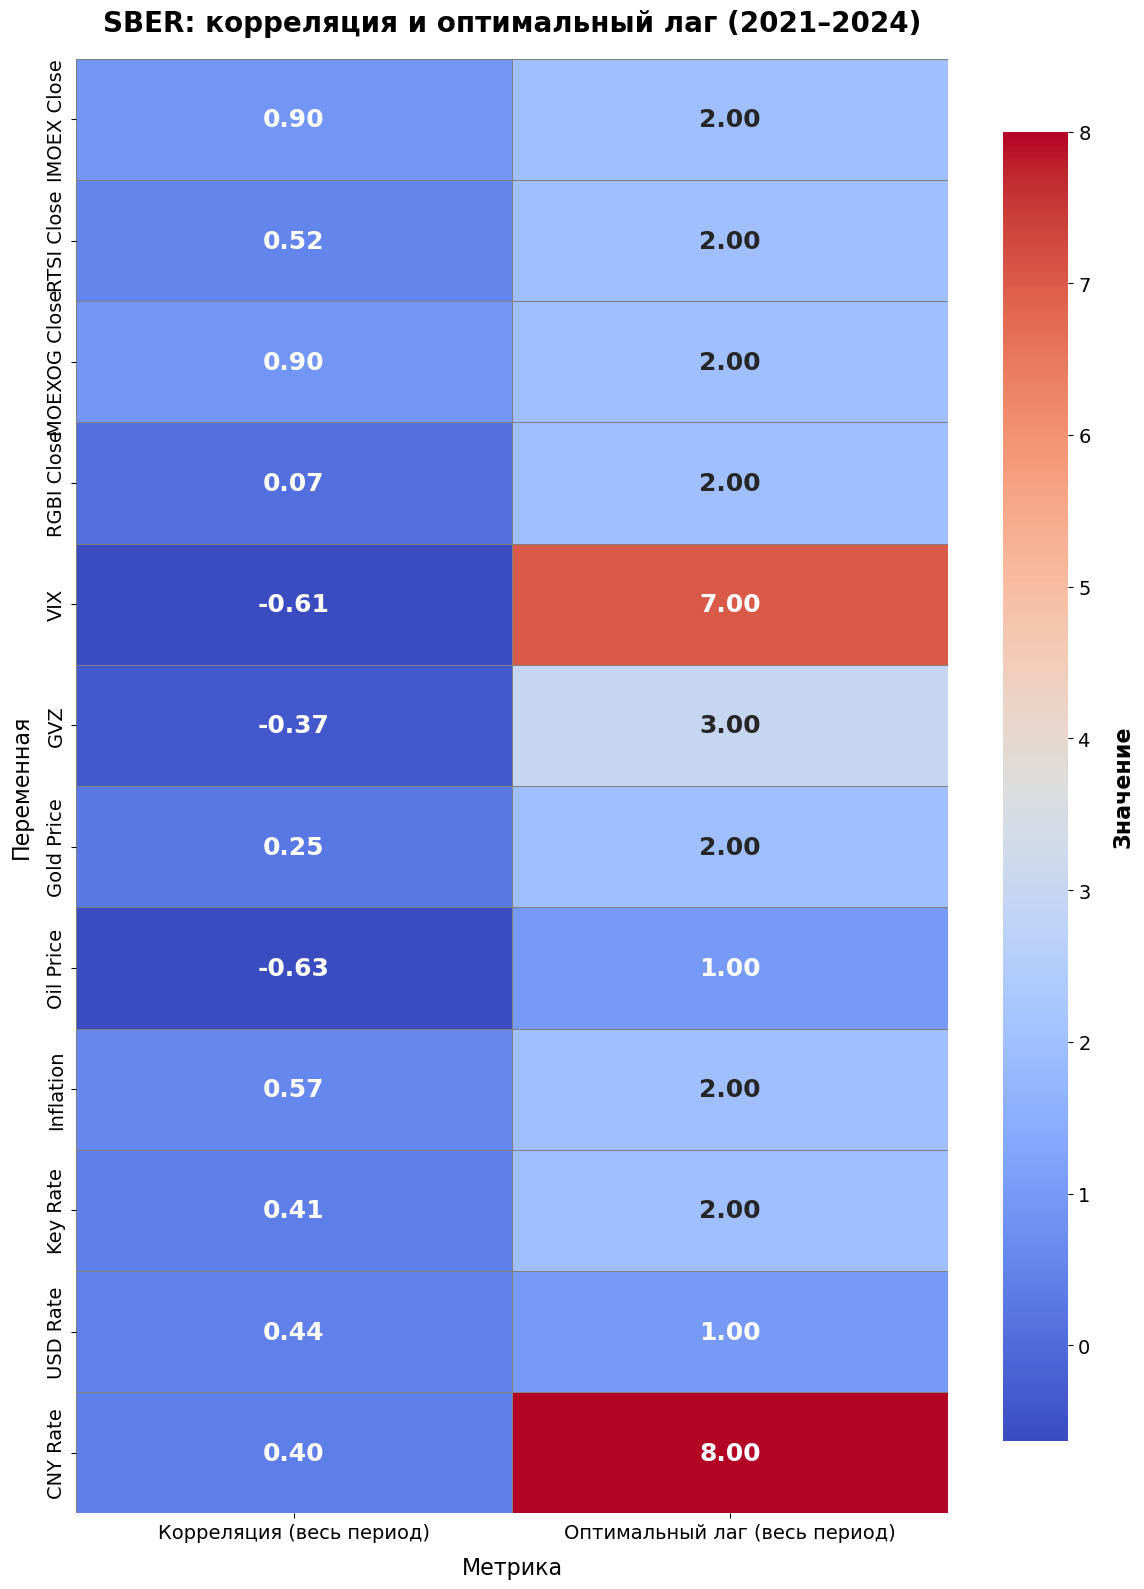

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import warnings

warnings.filterwarnings('ignore')

# === Загрузка и подготовка данных ===
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sber_merged_data.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]

# === Настройка переменных ===
target = 'Stock Close'
best_features = [col for col in df.columns if col != target]

df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === Годовые корреляции ===
years = [2021, 2022, 2023, 2024]
corr_by_year = {}

for year in years:
    df_year = df[df.index.year == year]
    corr = df_year.corr()
    corr_by_year[str(year)] = corr[target].drop(target)

corr_total = df.corr()
corr_by_year["Весь период"] = corr_total[target].drop(target)

corr_by_year_df = pd.DataFrame(corr_by_year)

# === Расчёт оптимальных лагов (Грейнджер) ===
lags_total = {}
for feature in best_features:
    try:
        test_result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        lags_total[feature] = optimal_lag
    except Exception:
        lags_total[feature] = np.nan

lags_total_series = pd.Series(lags_total, name="Оптимальный лаг (весь период)")
corr_total_series = corr_by_year_df["Весь период"]

arimax_total_selection = pd.concat([corr_total_series, lags_total_series], axis=1)
arimax_total_selection.columns = ["Корреляция (весь период)", "Оптимальный лаг (весь период)"]

# === Визуализация ===
plt.figure(figsize=(12, 16))
heatmap = sns.heatmap(
    arimax_total_selection,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.6,
    linecolor="gray",
    annot_kws={"size": 18, "weight": "bold"},
    cbar_kws={"label": "Значение", "shrink": 0.9}
)
plt.title("SBER: корреляция и оптимальный лаг (2021–2024)", fontsize=20, fontweight="bold", pad=20)
plt.xlabel("Метрика", fontsize=16, labelpad=10)
plt.ylabel("Переменная", fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(left=0.3)
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label("Значение", fontsize=16, weight="bold", labelpad=15)
plt.tight_layout()
plt.show()


🔄 Rolling forecast начат...


Прогнозирование:   0%|                                                                        | 0/182 [00:00<?, ?шаг/s]

📍 Итерация 0-2 | Дата: 2024-01-03


Прогнозирование:   1%|▎                                                               | 1/182 [00:04<14:59,  4.97s/шаг]

📍 Итерация 2-4 | Дата: 2024-01-05


Прогнозирование:   1%|▋                                                               | 2/182 [00:09<14:44,  4.91s/шаг]

📍 Итерация 4-6 | Дата: 2024-01-07


Прогнозирование:   2%|█                                                               | 3/182 [00:14<14:30,  4.87s/шаг]

📍 Итерация 6-8 | Дата: 2024-01-09


Прогнозирование:   2%|█▍                                                              | 4/182 [00:20<15:15,  5.14s/шаг]

📍 Итерация 8-10 | Дата: 2024-01-11


Прогнозирование:   3%|█▊                                                              | 5/182 [00:26<15:54,  5.39s/шаг]

📍 Итерация 10-12 | Дата: 2024-01-13


Прогнозирование:   3%|██                                                              | 6/182 [00:33<17:44,  6.05s/шаг]

📍 Итерация 12-14 | Дата: 2024-01-15


Прогнозирование:   4%|██▍                                                             | 7/182 [00:38<16:35,  5.69s/шаг]

📍 Итерация 14-16 | Дата: 2024-01-17


Прогнозирование:   4%|██▊                                                             | 8/182 [00:43<15:59,  5.52s/шаг]

📍 Итерация 16-18 | Дата: 2024-01-19


Прогнозирование:   5%|███▏                                                            | 9/182 [00:48<15:25,  5.35s/шаг]

📍 Итерация 18-20 | Дата: 2024-01-21


Прогнозирование:   5%|███▍                                                           | 10/182 [00:55<16:55,  5.90s/шаг]

📍 Итерация 20-22 | Дата: 2024-01-23


Прогнозирование:   6%|███▊                                                           | 11/182 [01:02<17:21,  6.09s/шаг]

📍 Итерация 22-24 | Дата: 2024-01-25


Прогнозирование:   7%|████▏                                                          | 12/182 [01:08<17:36,  6.22s/шаг]

📍 Итерация 24-26 | Дата: 2024-01-27


Прогнозирование:   7%|████▌                                                          | 13/182 [01:16<19:13,  6.82s/шаг]

📍 Итерация 26-28 | Дата: 2024-01-29


Прогнозирование:   8%|████▊                                                          | 14/182 [01:24<19:32,  6.98s/шаг]

📍 Итерация 28-30 | Дата: 2024-01-31


Прогнозирование:   8%|█████▏                                                         | 15/182 [01:31<19:39,  7.07s/шаг]

📍 Итерация 30-32 | Дата: 2024-02-02


Прогнозирование:   9%|█████▌                                                         | 16/182 [01:40<21:02,  7.61s/шаг]

📍 Итерация 32-34 | Дата: 2024-02-04


Прогнозирование:   9%|█████▉                                                         | 17/182 [01:48<21:39,  7.87s/шаг]

📍 Итерация 34-36 | Дата: 2024-02-06


Прогнозирование:  10%|██████▏                                                        | 18/182 [01:55<20:18,  7.43s/шаг]

📍 Итерация 36-38 | Дата: 2024-02-08


Прогнозирование:  10%|██████▌                                                        | 19/182 [02:04<21:58,  8.09s/шаг]

📍 Итерация 38-40 | Дата: 2024-02-10


Прогнозирование:  11%|██████▉                                                        | 20/182 [02:12<21:20,  7.90s/шаг]

📍 Итерация 40-42 | Дата: 2024-02-12


Прогнозирование:  12%|███████▎                                                       | 21/182 [02:21<22:14,  8.29s/шаг]

📍 Итерация 42-44 | Дата: 2024-02-14


Прогнозирование:  12%|███████▌                                                       | 22/182 [02:28<21:20,  8.00s/шаг]

📍 Итерация 44-46 | Дата: 2024-02-16


Прогнозирование:  13%|███████▉                                                       | 23/182 [02:36<20:34,  7.77s/шаг]

📍 Итерация 46-48 | Дата: 2024-02-18


Прогнозирование:  13%|████████▎                                                      | 24/182 [02:43<20:09,  7.66s/шаг]

📍 Итерация 48-50 | Дата: 2024-02-20


Прогнозирование:  14%|████████▋                                                      | 25/182 [02:51<19:58,  7.63s/шаг]

📍 Итерация 50-52 | Дата: 2024-02-22


Прогнозирование:  14%|█████████                                                      | 26/182 [02:55<17:40,  6.80s/шаг]

📍 Итерация 52-54 | Дата: 2024-02-24


Прогнозирование:  15%|█████████▎                                                     | 27/182 [03:02<17:07,  6.63s/шаг]

📍 Итерация 54-56 | Дата: 2024-02-26


Прогнозирование:  15%|█████████▋                                                     | 28/182 [03:08<16:54,  6.59s/шаг]

📍 Итерация 56-58 | Дата: 2024-02-28


Прогнозирование:  16%|██████████                                                     | 29/182 [03:15<16:48,  6.59s/шаг]

📍 Итерация 58-60 | Дата: 2024-03-01


Прогнозирование:  16%|██████████▍                                                    | 30/182 [03:22<17:32,  6.92s/шаг]

📍 Итерация 60-62 | Дата: 2024-03-03


Прогнозирование:  17%|██████████▋                                                    | 31/182 [03:30<17:52,  7.10s/шаг]

📍 Итерация 62-64 | Дата: 2024-03-05


Прогнозирование:  18%|███████████                                                    | 32/182 [03:39<19:16,  7.71s/шаг]

📍 Итерация 64-66 | Дата: 2024-03-07


Прогнозирование:  18%|███████████▍                                                   | 33/182 [03:44<17:13,  6.94s/шаг]

📍 Итерация 66-68 | Дата: 2024-03-09


Прогнозирование:  19%|███████████▊                                                   | 34/182 [03:49<15:51,  6.43s/шаг]

📍 Итерация 68-70 | Дата: 2024-03-11


Прогнозирование:  19%|████████████                                                   | 35/182 [03:57<16:26,  6.71s/шаг]

📍 Итерация 70-72 | Дата: 2024-03-13


Прогнозирование:  20%|████████████▍                                                  | 36/182 [04:02<15:24,  6.33s/шаг]

📍 Итерация 72-74 | Дата: 2024-03-15


Прогнозирование:  20%|████████████▊                                                  | 37/182 [04:12<17:43,  7.33s/шаг]

📍 Итерация 74-76 | Дата: 2024-03-17


Прогнозирование:  21%|█████████████▏                                                 | 38/182 [04:18<16:32,  6.89s/шаг]

📍 Итерация 76-78 | Дата: 2024-03-19


Прогнозирование:  21%|█████████████▌                                                 | 39/182 [04:25<16:27,  6.91s/шаг]

📍 Итерация 78-80 | Дата: 2024-03-21


Прогнозирование:  22%|█████████████▊                                                 | 40/182 [04:31<16:13,  6.86s/шаг]

📍 Итерация 80-82 | Дата: 2024-03-23


Прогнозирование:  23%|██████████████▏                                                | 41/182 [04:37<15:08,  6.45s/шаг]

📍 Итерация 82-84 | Дата: 2024-03-25


Прогнозирование:  23%|██████████████▌                                                | 42/182 [04:44<15:12,  6.52s/шаг]

📍 Итерация 84-86 | Дата: 2024-03-27


Прогнозирование:  24%|██████████████▉                                                | 43/182 [04:50<15:19,  6.62s/шаг]

📍 Итерация 86-88 | Дата: 2024-03-29


Прогнозирование:  24%|███████████████▏                                               | 44/182 [04:57<15:21,  6.68s/шаг]

📍 Итерация 88-90 | Дата: 2024-03-31


Прогнозирование:  25%|███████████████▌                                               | 45/182 [05:03<14:33,  6.38s/шаг]

📍 Итерация 90-92 | Дата: 2024-04-02


Прогнозирование:  25%|███████████████▉                                               | 46/182 [05:09<14:02,  6.19s/шаг]

📍 Итерация 92-94 | Дата: 2024-04-04


Прогнозирование:  26%|████████████████▎                                              | 47/182 [05:14<13:36,  6.05s/шаг]

📍 Итерация 94-96 | Дата: 2024-04-06


Прогнозирование:  26%|████████████████▌                                              | 48/182 [05:20<13:00,  5.83s/шаг]

📍 Итерация 96-98 | Дата: 2024-04-08


Прогнозирование:  27%|████████████████▉                                              | 49/182 [05:26<13:13,  5.97s/шаг]

📍 Итерация 98-100 | Дата: 2024-04-10


Прогнозирование:  27%|█████████████████▎                                             | 50/182 [05:35<14:59,  6.81s/шаг]

📍 Итерация 100-102 | Дата: 2024-04-12


Прогнозирование:  28%|█████████████████▋                                             | 51/182 [05:42<15:17,  7.00s/шаг]

📍 Итерация 102-104 | Дата: 2024-04-14


Прогнозирование:  29%|██████████████████                                             | 52/182 [05:48<14:18,  6.60s/шаг]

📍 Итерация 104-106 | Дата: 2024-04-16


Прогнозирование:  29%|██████████████████▎                                            | 53/182 [05:53<13:28,  6.27s/шаг]

📍 Итерация 106-108 | Дата: 2024-04-18


Прогнозирование:  30%|██████████████████▋                                            | 54/182 [05:59<12:56,  6.06s/шаг]

📍 Итерация 108-110 | Дата: 2024-04-20


Прогнозирование:  30%|███████████████████                                            | 55/182 [06:04<12:23,  5.85s/шаг]

📍 Итерация 110-112 | Дата: 2024-04-22


Прогнозирование:  31%|███████████████████▍                                           | 56/182 [06:13<14:06,  6.72s/шаг]

📍 Итерация 112-114 | Дата: 2024-04-24


Прогнозирование:  31%|███████████████████▋                                           | 57/182 [06:19<13:46,  6.61s/шаг]

📍 Итерация 114-116 | Дата: 2024-04-26


Прогнозирование:  32%|████████████████████                                           | 58/182 [06:27<14:00,  6.77s/шаг]

📍 Итерация 116-118 | Дата: 2024-04-28


Прогнозирование:  32%|████████████████████▍                                          | 59/182 [06:34<14:29,  7.07s/шаг]

📍 Итерация 118-120 | Дата: 2024-04-30


Прогнозирование:  33%|████████████████████▊                                          | 60/182 [06:42<14:47,  7.27s/шаг]

📍 Итерация 120-122 | Дата: 2024-05-02


Прогнозирование:  34%|█████████████████████                                          | 61/182 [06:50<14:56,  7.41s/шаг]

📍 Итерация 122-124 | Дата: 2024-05-04


Прогнозирование:  34%|█████████████████████▍                                         | 62/182 [06:59<15:53,  7.95s/шаг]

📍 Итерация 124-126 | Дата: 2024-05-06


Прогнозирование:  35%|█████████████████████▊                                         | 63/182 [07:06<15:25,  7.78s/шаг]

📍 Итерация 126-128 | Дата: 2024-05-08


Прогнозирование:  35%|██████████████████████▏                                        | 64/182 [07:14<15:17,  7.77s/шаг]

📍 Итерация 128-130 | Дата: 2024-05-10


Прогнозирование:  36%|██████████████████████▌                                        | 65/182 [07:22<15:06,  7.75s/шаг]

📍 Итерация 130-132 | Дата: 2024-05-12


Прогнозирование:  36%|██████████████████████▊                                        | 66/182 [07:33<17:07,  8.85s/шаг]

📍 Итерация 132-134 | Дата: 2024-05-14


Прогнозирование:  37%|███████████████████████▏                                       | 67/182 [07:42<16:38,  8.68s/шаг]

📍 Итерация 134-136 | Дата: 2024-05-16


Прогнозирование:  37%|███████████████████████▌                                       | 68/182 [07:48<15:12,  8.00s/шаг]

📍 Итерация 136-138 | Дата: 2024-05-18


Прогнозирование:  38%|███████████████████████▉                                       | 69/182 [07:55<14:41,  7.80s/шаг]

📍 Итерация 138-140 | Дата: 2024-05-20


Прогнозирование:  38%|████████████████████████▏                                      | 70/182 [08:03<14:31,  7.78s/шаг]

📍 Итерация 140-142 | Дата: 2024-05-22


Прогнозирование:  39%|████████████████████████▌                                      | 71/182 [08:10<13:49,  7.48s/шаг]

📍 Итерация 142-144 | Дата: 2024-05-24


Прогнозирование:  40%|████████████████████████▉                                      | 72/182 [08:19<14:33,  7.94s/шаг]

📍 Итерация 144-146 | Дата: 2024-05-26


Прогнозирование:  40%|█████████████████████████▎                                     | 73/182 [08:27<14:44,  8.11s/шаг]

📍 Итерация 146-148 | Дата: 2024-05-28


Прогнозирование:  41%|█████████████████████████▌                                     | 74/182 [08:34<13:39,  7.59s/шаг]

📍 Итерация 148-150 | Дата: 2024-05-30


Прогнозирование:  41%|█████████████████████████▉                                     | 75/182 [08:40<13:02,  7.32s/шаг]

📍 Итерация 150-152 | Дата: 2024-06-01


Прогнозирование:  42%|██████████████████████████▎                                    | 76/182 [08:49<13:20,  7.55s/шаг]

📍 Итерация 152-154 | Дата: 2024-06-03


Прогнозирование:  42%|██████████████████████████▋                                    | 77/182 [08:56<13:24,  7.66s/шаг]

📍 Итерация 154-156 | Дата: 2024-06-05


Прогнозирование:  43%|███████████████████████████                                    | 78/182 [09:04<13:07,  7.57s/шаг]

📍 Итерация 156-158 | Дата: 2024-06-07


Прогнозирование:  43%|███████████████████████████▎                                   | 79/182 [09:09<12:00,  7.00s/шаг]

📍 Итерация 158-160 | Дата: 2024-06-09


Прогнозирование:  44%|███████████████████████████▋                                   | 80/182 [09:16<11:42,  6.89s/шаг]

📍 Итерация 160-162 | Дата: 2024-06-11


Прогнозирование:  45%|████████████████████████████                                   | 81/182 [09:23<11:23,  6.77s/шаг]

📍 Итерация 162-164 | Дата: 2024-06-13


Прогнозирование:  45%|████████████████████████████▍                                  | 82/182 [09:29<11:14,  6.75s/шаг]

📍 Итерация 164-166 | Дата: 2024-06-15


Прогнозирование:  46%|████████████████████████████▋                                  | 83/182 [09:36<11:05,  6.72s/шаг]

📍 Итерация 166-168 | Дата: 2024-06-17


Прогнозирование:  46%|█████████████████████████████                                  | 84/182 [09:42<10:29,  6.42s/шаг]

📍 Итерация 168-170 | Дата: 2024-06-19


Прогнозирование:  47%|█████████████████████████████▍                                 | 85/182 [09:49<10:57,  6.78s/шаг]

📍 Итерация 170-172 | Дата: 2024-06-21


Прогнозирование:  47%|█████████████████████████████▊                                 | 86/182 [09:58<11:45,  7.35s/шаг]

📍 Итерация 172-174 | Дата: 2024-06-23


Прогнозирование:  48%|██████████████████████████████                                 | 87/182 [10:06<11:58,  7.56s/шаг]

📍 Итерация 174-176 | Дата: 2024-06-25


Прогнозирование:  48%|██████████████████████████████▍                                | 88/182 [10:16<12:45,  8.14s/шаг]

📍 Итерация 176-178 | Дата: 2024-06-27


Прогнозирование:  49%|██████████████████████████████▊                                | 89/182 [10:22<12:01,  7.76s/шаг]

📍 Итерация 178-180 | Дата: 2024-06-29


Прогнозирование:  49%|███████████████████████████████▏                               | 90/182 [10:27<10:28,  6.83s/шаг]

📍 Итерация 180-182 | Дата: 2024-07-01


Прогнозирование:  50%|███████████████████████████████▌                               | 91/182 [10:36<11:06,  7.33s/шаг]

📍 Итерация 182-184 | Дата: 2024-07-03


Прогнозирование:  51%|███████████████████████████████▊                               | 92/182 [10:42<10:45,  7.18s/шаг]

📍 Итерация 184-186 | Дата: 2024-07-05


Прогнозирование:  51%|████████████████████████████████▏                              | 93/182 [10:50<10:40,  7.19s/шаг]

📍 Итерация 186-188 | Дата: 2024-07-07


Прогнозирование:  52%|████████████████████████████████▌                              | 94/182 [10:57<10:47,  7.36s/шаг]

📍 Итерация 188-190 | Дата: 2024-07-09


Прогнозирование:  52%|████████████████████████████████▉                              | 95/182 [11:02<09:32,  6.58s/шаг]

📍 Итерация 190-192 | Дата: 2024-07-11


Прогнозирование:  53%|█████████████████████████████████▏                             | 96/182 [11:08<08:56,  6.24s/шаг]

📍 Итерация 192-194 | Дата: 2024-07-13


Прогнозирование:  53%|█████████████████████████████████▌                             | 97/182 [11:15<09:28,  6.69s/шаг]

📍 Итерация 194-196 | Дата: 2024-07-15


Прогнозирование:  54%|█████████████████████████████████▉                             | 98/182 [11:23<09:42,  6.94s/шаг]

📍 Итерация 196-198 | Дата: 2024-07-17


Прогнозирование:  54%|██████████████████████████████████▎                            | 99/182 [11:30<09:29,  6.87s/шаг]

📍 Итерация 198-200 | Дата: 2024-07-19


Прогнозирование:  55%|██████████████████████████████████                            | 100/182 [11:36<09:20,  6.84s/шаг]

📍 Итерация 200-202 | Дата: 2024-07-21


Прогнозирование:  55%|██████████████████████████████████▍                           | 101/182 [11:43<09:15,  6.86s/шаг]

📍 Итерация 202-204 | Дата: 2024-07-23


Прогнозирование:  56%|██████████████████████████████████▋                           | 102/182 [11:51<09:20,  7.00s/шаг]

📍 Итерация 204-206 | Дата: 2024-07-25


Прогнозирование:  57%|███████████████████████████████████                           | 103/182 [11:58<09:31,  7.23s/шаг]

📍 Итерация 206-208 | Дата: 2024-07-27


Прогнозирование:  57%|███████████████████████████████████▍                          | 104/182 [12:06<09:28,  7.29s/шаг]

📍 Итерация 208-210 | Дата: 2024-07-29


Прогнозирование:  58%|███████████████████████████████████▊                          | 105/182 [12:13<09:21,  7.29s/шаг]

📍 Итерация 210-212 | Дата: 2024-07-31


Прогнозирование:  58%|████████████████████████████████████                          | 106/182 [12:20<09:05,  7.18s/шаг]

📍 Итерация 212-214 | Дата: 2024-08-02


Прогнозирование:  59%|████████████████████████████████████▍                         | 107/182 [12:28<09:13,  7.38s/шаг]

📍 Итерация 214-216 | Дата: 2024-08-04


Прогнозирование:  59%|████████████████████████████████████▊                         | 108/182 [12:33<08:08,  6.61s/шаг]

📍 Итерация 216-218 | Дата: 2024-08-06


Прогнозирование:  60%|█████████████████████████████████████▏                        | 109/182 [12:37<07:20,  6.03s/шаг]

📍 Итерация 218-220 | Дата: 2024-08-08


Прогнозирование:  60%|█████████████████████████████████████▍                        | 110/182 [12:43<07:16,  6.06s/шаг]

📍 Итерация 220-222 | Дата: 2024-08-10


Прогнозирование:  61%|█████████████████████████████████████▊                        | 111/182 [12:49<07:09,  6.05s/шаг]

📍 Итерация 222-224 | Дата: 2024-08-12


Прогнозирование:  62%|██████████████████████████████████████▏                       | 112/182 [12:55<06:43,  5.77s/шаг]

📍 Итерация 224-226 | Дата: 2024-08-14


Прогнозирование:  62%|██████████████████████████████████████▍                       | 113/182 [13:02<07:08,  6.22s/шаг]

📍 Итерация 226-228 | Дата: 2024-08-16


Прогнозирование:  63%|██████████████████████████████████████▊                       | 114/182 [13:08<06:52,  6.07s/шаг]

📍 Итерация 228-230 | Дата: 2024-08-18


Прогнозирование:  63%|███████████████████████████████████████▏                      | 115/182 [13:13<06:43,  6.03s/шаг]

📍 Итерация 230-232 | Дата: 2024-08-20


Прогнозирование:  64%|███████████████████████████████████████▌                      | 116/182 [13:19<06:31,  5.94s/шаг]

📍 Итерация 232-234 | Дата: 2024-08-22


Прогнозирование:  64%|███████████████████████████████████████▊                      | 117/182 [13:26<06:40,  6.16s/шаг]

📍 Итерация 234-236 | Дата: 2024-08-24


Прогнозирование:  65%|████████████████████████████████████████▏                     | 118/182 [13:30<06:03,  5.68s/шаг]

📍 Итерация 236-238 | Дата: 2024-08-26


Прогнозирование:  65%|████████████████████████████████████████▌                     | 119/182 [13:38<06:26,  6.14s/шаг]

📍 Итерация 238-240 | Дата: 2024-08-28


Прогнозирование:  66%|████████████████████████████████████████▉                     | 120/182 [13:45<06:50,  6.62s/шаг]

📍 Итерация 240-242 | Дата: 2024-08-30


Прогнозирование:  66%|█████████████████████████████████████████▏                    | 121/182 [13:54<07:20,  7.22s/шаг]

📍 Итерация 242-244 | Дата: 2024-09-01


Прогнозирование:  67%|█████████████████████████████████████████▌                    | 122/182 [14:01<07:13,  7.23s/шаг]

📍 Итерация 244-246 | Дата: 2024-09-03


Прогнозирование:  68%|█████████████████████████████████████████▉                    | 123/182 [14:10<07:34,  7.71s/шаг]

📍 Итерация 246-248 | Дата: 2024-09-05


Прогнозирование:  68%|██████████████████████████████████████████▏                   | 124/182 [14:18<07:36,  7.87s/шаг]

📍 Итерация 248-250 | Дата: 2024-09-07


Прогнозирование:  69%|██████████████████████████████████████████▌                   | 125/182 [14:26<07:17,  7.68s/шаг]

📍 Итерация 250-252 | Дата: 2024-09-09


Прогнозирование:  69%|██████████████████████████████████████████▉                   | 126/182 [14:34<07:15,  7.78s/шаг]

📍 Итерация 252-254 | Дата: 2024-09-11


Прогнозирование:  70%|███████████████████████████████████████████▎                  | 127/182 [14:42<07:16,  7.94s/шаг]

📍 Итерация 254-256 | Дата: 2024-09-13


Прогнозирование:  70%|███████████████████████████████████████████▌                  | 128/182 [14:50<07:16,  8.09s/шаг]

📍 Итерация 256-258 | Дата: 2024-09-15


Прогнозирование:  71%|███████████████████████████████████████████▉                  | 129/182 [14:58<06:58,  7.90s/шаг]

📍 Итерация 258-260 | Дата: 2024-09-17


Прогнозирование:  71%|████████████████████████████████████████████▎                 | 130/182 [15:07<07:06,  8.21s/шаг]

📍 Итерация 260-262 | Дата: 2024-09-19


Прогнозирование:  72%|████████████████████████████████████████████▋                 | 131/182 [15:16<07:08,  8.41s/шаг]

📍 Итерация 262-264 | Дата: 2024-09-21


Прогнозирование:  73%|████████████████████████████████████████████▉                 | 132/182 [15:21<06:07,  7.35s/шаг]

📍 Итерация 264-266 | Дата: 2024-09-23


Прогнозирование:  73%|█████████████████████████████████████████████▎                | 133/182 [15:28<05:57,  7.30s/шаг]

📍 Итерация 266-268 | Дата: 2024-09-25


Прогнозирование:  74%|█████████████████████████████████████████████▋                | 134/182 [15:35<05:49,  7.28s/шаг]

📍 Итерация 268-270 | Дата: 2024-09-27


Прогнозирование:  74%|█████████████████████████████████████████████▉                | 135/182 [15:42<05:44,  7.33s/шаг]

📍 Итерация 270-272 | Дата: 2024-09-29


Прогнозирование:  75%|██████████████████████████████████████████████▎               | 136/182 [15:50<05:47,  7.56s/шаг]

📍 Итерация 272-274 | Дата: 2024-10-01


Прогнозирование:  75%|██████████████████████████████████████████████▋               | 137/182 [15:59<05:57,  7.95s/шаг]

📍 Итерация 274-276 | Дата: 2024-10-03


Прогнозирование:  76%|███████████████████████████████████████████████               | 138/182 [16:08<05:59,  8.18s/шаг]

📍 Итерация 276-278 | Дата: 2024-10-05


Прогнозирование:  76%|███████████████████████████████████████████████▎              | 139/182 [16:15<05:40,  7.93s/шаг]

📍 Итерация 278-280 | Дата: 2024-10-07


Прогнозирование:  77%|███████████████████████████████████████████████▋              | 140/182 [16:24<05:43,  8.17s/шаг]

📍 Итерация 280-282 | Дата: 2024-10-09


Прогнозирование:  77%|████████████████████████████████████████████████              | 141/182 [16:35<06:07,  8.97s/шаг]

📍 Итерация 282-284 | Дата: 2024-10-11


Прогнозирование:  78%|████████████████████████████████████████████████▎             | 142/182 [16:42<05:33,  8.34s/шаг]

📍 Итерация 284-286 | Дата: 2024-10-13


Прогнозирование:  79%|████████████████████████████████████████████████▋             | 143/182 [16:49<05:09,  7.93s/шаг]

📍 Итерация 286-288 | Дата: 2024-10-15


Прогнозирование:  79%|█████████████████████████████████████████████████             | 144/182 [16:55<04:43,  7.46s/шаг]

📍 Итерация 288-290 | Дата: 2024-10-17


Прогнозирование:  80%|█████████████████████████████████████████████████▍            | 145/182 [17:02<04:31,  7.33s/шаг]

📍 Итерация 290-292 | Дата: 2024-10-19


Прогнозирование:  80%|█████████████████████████████████████████████████▋            | 146/182 [17:09<04:19,  7.20s/шаг]

📍 Итерация 292-294 | Дата: 2024-10-21


Прогнозирование:  81%|██████████████████████████████████████████████████            | 147/182 [17:16<04:06,  7.06s/шаг]

📍 Итерация 294-296 | Дата: 2024-10-23


Прогнозирование:  81%|██████████████████████████████████████████████████▍           | 148/182 [17:22<03:55,  6.93s/шаг]

📍 Итерация 296-298 | Дата: 2024-10-25


Прогнозирование:  82%|██████████████████████████████████████████████████▊           | 149/182 [17:29<03:42,  6.73s/шаг]

📍 Итерация 298-300 | Дата: 2024-10-27


Прогнозирование:  82%|███████████████████████████████████████████████████           | 150/182 [17:34<03:23,  6.36s/шаг]

📍 Итерация 300-302 | Дата: 2024-10-29


Прогнозирование:  83%|███████████████████████████████████████████████████▍          | 151/182 [17:43<03:36,  6.97s/шаг]

📍 Итерация 302-304 | Дата: 2024-10-31


Прогнозирование:  84%|███████████████████████████████████████████████████▊          | 152/182 [17:50<03:36,  7.21s/шаг]

📍 Итерация 304-306 | Дата: 2024-11-02


Прогнозирование:  84%|████████████████████████████████████████████████████          | 153/182 [17:58<03:31,  7.28s/шаг]

📍 Итерация 306-308 | Дата: 2024-11-04


Прогнозирование:  85%|████████████████████████████████████████████████████▍         | 154/182 [18:04<03:16,  7.03s/шаг]

📍 Итерация 308-310 | Дата: 2024-11-06


Прогнозирование:  85%|████████████████████████████████████████████████████▊         | 155/182 [18:10<02:58,  6.60s/шаг]

📍 Итерация 310-312 | Дата: 2024-11-08


Прогнозирование:  86%|█████████████████████████████████████████████████████▏        | 156/182 [18:17<02:56,  6.78s/шаг]

📍 Итерация 312-314 | Дата: 2024-11-10


Прогнозирование:  86%|█████████████████████████████████████████████████████▍        | 157/182 [18:23<02:42,  6.49s/шаг]

📍 Итерация 314-316 | Дата: 2024-11-12


Прогнозирование:  87%|█████████████████████████████████████████████████████▊        | 158/182 [18:30<02:38,  6.60s/шаг]

📍 Итерация 316-318 | Дата: 2024-11-14


Прогнозирование:  87%|██████████████████████████████████████████████████████▏       | 159/182 [18:35<02:21,  6.13s/шаг]

📍 Итерация 318-320 | Дата: 2024-11-16


Прогнозирование:  88%|██████████████████████████████████████████████████████▌       | 160/182 [18:40<02:11,  5.97s/шаг]

📍 Итерация 320-322 | Дата: 2024-11-18


Прогнозирование:  88%|██████████████████████████████████████████████████████▊       | 161/182 [18:47<02:07,  6.08s/шаг]

📍 Итерация 322-324 | Дата: 2024-11-20


Прогнозирование:  89%|███████████████████████████████████████████████████████▏      | 162/182 [18:52<01:57,  5.85s/шаг]

📍 Итерация 324-326 | Дата: 2024-11-22


Прогнозирование:  90%|███████████████████████████████████████████████████████▌      | 163/182 [18:59<01:58,  6.22s/шаг]

📍 Итерация 326-328 | Дата: 2024-11-24


Прогнозирование:  90%|███████████████████████████████████████████████████████▊      | 164/182 [19:06<01:55,  6.41s/шаг]

📍 Итерация 328-330 | Дата: 2024-11-26


Прогнозирование:  91%|████████████████████████████████████████████████████████▏     | 165/182 [19:16<02:06,  7.44s/шаг]

📍 Итерация 330-332 | Дата: 2024-11-28


Прогнозирование:  91%|████████████████████████████████████████████████████████▌     | 166/182 [19:23<01:57,  7.37s/шаг]

📍 Итерация 332-334 | Дата: 2024-11-30


Прогнозирование:  92%|████████████████████████████████████████████████████████▉     | 167/182 [19:31<01:51,  7.46s/шаг]

📍 Итерация 334-336 | Дата: 2024-12-02


Прогнозирование:  92%|█████████████████████████████████████████████████████████▏    | 168/182 [19:37<01:39,  7.13s/шаг]

📍 Итерация 336-338 | Дата: 2024-12-04


Прогнозирование:  93%|█████████████████████████████████████████████████████████▌    | 169/182 [19:43<01:29,  6.85s/шаг]

📍 Итерация 338-340 | Дата: 2024-12-06


Прогнозирование:  93%|█████████████████████████████████████████████████████████▉    | 170/182 [19:52<01:27,  7.32s/шаг]

📍 Итерация 340-342 | Дата: 2024-12-08


Прогнозирование:  94%|██████████████████████████████████████████████████████████▎   | 171/182 [20:00<01:23,  7.56s/шаг]

📍 Итерация 342-344 | Дата: 2024-12-10


Прогнозирование:  95%|██████████████████████████████████████████████████████████▌   | 172/182 [20:08<01:17,  7.78s/шаг]

📍 Итерация 344-346 | Дата: 2024-12-12


Прогнозирование:  95%|██████████████████████████████████████████████████████████▉   | 173/182 [20:17<01:13,  8.17s/шаг]

📍 Итерация 346-348 | Дата: 2024-12-14


Прогнозирование:  96%|███████████████████████████████████████████████████████████▎  | 174/182 [20:26<01:06,  8.29s/шаг]

📍 Итерация 348-350 | Дата: 2024-12-16


Прогнозирование:  96%|███████████████████████████████████████████████████████████▌  | 175/182 [20:36<01:02,  8.87s/шаг]

📍 Итерация 350-352 | Дата: 2024-12-18


Прогнозирование:  97%|███████████████████████████████████████████████████████████▉  | 176/182 [20:45<00:53,  8.94s/шаг]

📍 Итерация 352-354 | Дата: 2024-12-20


Прогнозирование:  97%|████████████████████████████████████████████████████████████▎ | 177/182 [20:54<00:44,  8.86s/шаг]

📍 Итерация 354-356 | Дата: 2024-12-22


Прогнозирование:  98%|████████████████████████████████████████████████████████████▋ | 178/182 [21:01<00:33,  8.48s/шаг]

📍 Итерация 356-358 | Дата: 2024-12-24


Прогнозирование:  98%|████████████████████████████████████████████████████████████▉ | 179/182 [21:10<00:25,  8.49s/шаг]

📍 Итерация 358-360 | Дата: 2024-12-26


Прогнозирование:  99%|█████████████████████████████████████████████████████████████▎| 180/182 [21:19<00:17,  8.64s/шаг]

📍 Итерация 360-362 | Дата: 2024-12-28


Прогнозирование:  99%|█████████████████████████████████████████████████████████████▋| 181/182 [21:27<00:08,  8.41s/шаг]

📍 Итерация 362-363 | Дата: 2024-12-30


Прогнозирование: 100%|██████████████████████████████████████████████████████████████| 182/182 [21:36<00:00,  7.12s/шаг]


✅ Rolling прогноз завершён за 1296.3 секунд.

📊 Оценка качества прогноза по SBER:
MAE  = 1.587
RMSE = 2.549
MAPE = 0.58%


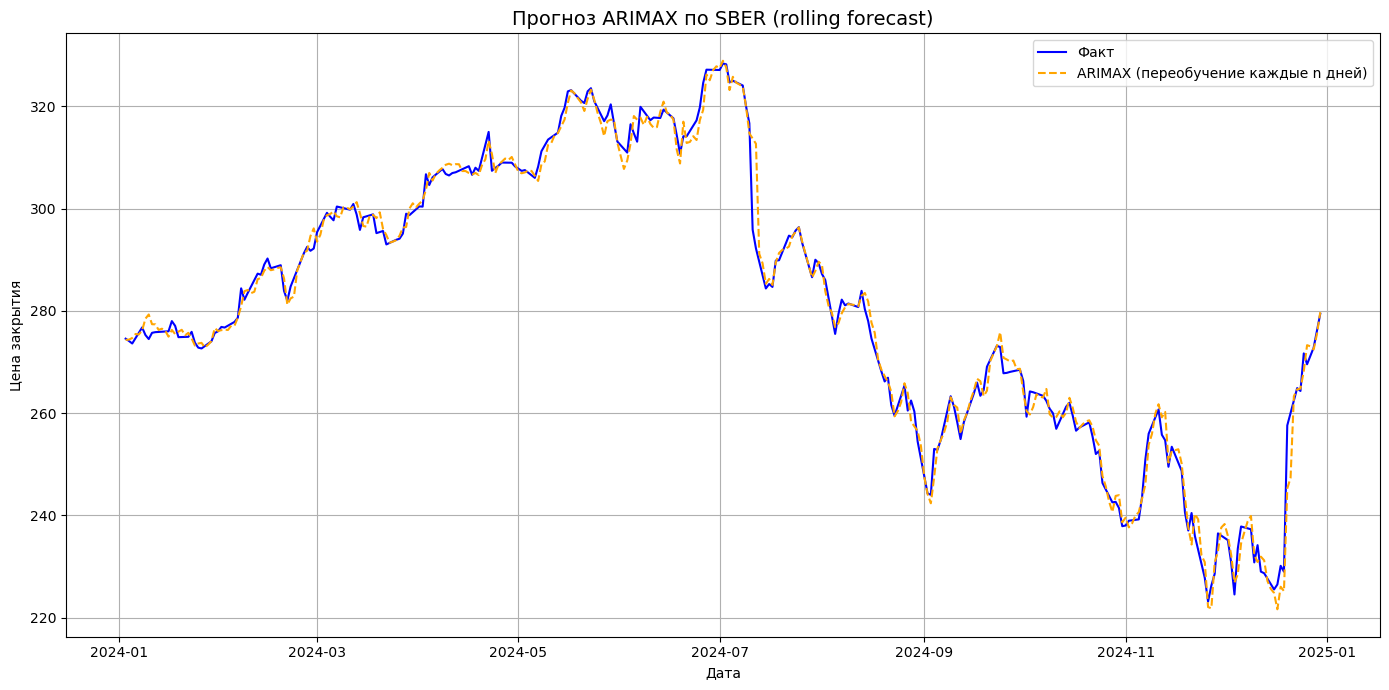

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm
import time
import warnings

warnings.filterwarnings('ignore')

# === Загрузка данных ===
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/sber_merged_data.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]

# === Целевая и экзогенные переменные ===
target = "Stock Close"
best_features = ["IMOEX Close", "MOEXOG Close", "CNY Rate"]
best_features = [f for f in best_features if f in df.columns]

df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === Лаги через Грейнджера ===
optimal_lags = {}
for feature in best_features:
    try:
        result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        optimal_lags[feature] = optimal_lag
    except Exception:
        continue

# === Создание лагов ===
def create_lags(data, lags_dict):
    data_copy = data.copy()
    for feature, lag in lags_dict.items():
        for l in range(1, lag + 1):
            data_copy[f'{feature}_lag{l}'] = data_copy[feature].shift(l)
    return data_copy.dropna()

df_lagged = create_lags(df, optimal_lags)

# === Train/Test split ===
split_idx = int(len(df_lagged) * 0.75)
train_lagged = df_lagged.iloc[:split_idx]
test_lagged = df_lagged.iloc[split_idx:]

y_train = train_lagged[target]
X_train = train_lagged.drop(columns=[target])
y_test = test_lagged[target]
X_test = test_lagged.drop(columns=[target])

# === Rolling forecast ===
forecast_list = []
n_days = min(optimal_lags.values())

print("🔄 Rolling forecast начат...")
start_time = time.time()

for i in tqdm(range(0, len(X_test), n_days), desc="Прогнозирование", unit="шаг"):
    end_i = min(i + n_days, len(X_test))
    if end_i <= i:
        break

    current_y_train = pd.concat([y_train, y_test.iloc[:i]])
    current_X_train = pd.concat([X_train, X_test.iloc[:i]])
    current_X_forecast = X_test.iloc[i:end_i]

    print(f"📍 Итерация {i}-{end_i} | Дата: {y_test.index[i].date()}")

    optimal_arima = auto_arima(current_y_train, exogenous=current_X_train, seasonal=False, d=1,
                               trace=False, stepwise=True, suppress_warnings=True, max_p=3, max_q=3)

    model = SARIMAX(current_y_train, exog=current_X_train, order=optimal_arima.order)
    model_fit = model.fit(maxiter=500, disp=False)

    preds = model_fit.forecast(steps=len(current_X_forecast), exog=current_X_forecast)
    forecast_list.extend(preds)

elapsed_time = time.time() - start_time
print(f"✅ Rolling прогноз завершён за {elapsed_time:.1f} секунд.")

# === Сбор результатов ===
forecast_df = pd.DataFrame({
    'Date': y_test.index[:len(forecast_list)],
    'Actual Stock Close': y_test.values[:len(forecast_list)],
    'Forecast Stock Close': forecast_list
}).set_index('Date')

# === Метрики ===
mae = mean_absolute_error(forecast_df['Actual Stock Close'], forecast_df['Forecast Stock Close'])
rmse = np.sqrt(mean_squared_error(forecast_df['Actual Stock Close'], forecast_df['Forecast Stock Close']))
mape = np.mean(np.abs((forecast_df['Actual Stock Close'] - forecast_df['Forecast Stock Close']) / forecast_df['Actual Stock Close'])) * 100

print(f"\n📊 Оценка качества прогноза по SBER:")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"MAPE = {mape:.2f}%")

# === Визуализация ===
plt.figure(figsize=(14, 7))
plt.plot(forecast_df.index, forecast_df['Actual Stock Close'], label='Факт', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast Stock Close'], label='ARIMAX (переобучение каждые n дней)', color='orange', linestyle='--')
plt.title('Прогноз ARIMAX по SBER (rolling forecast)', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


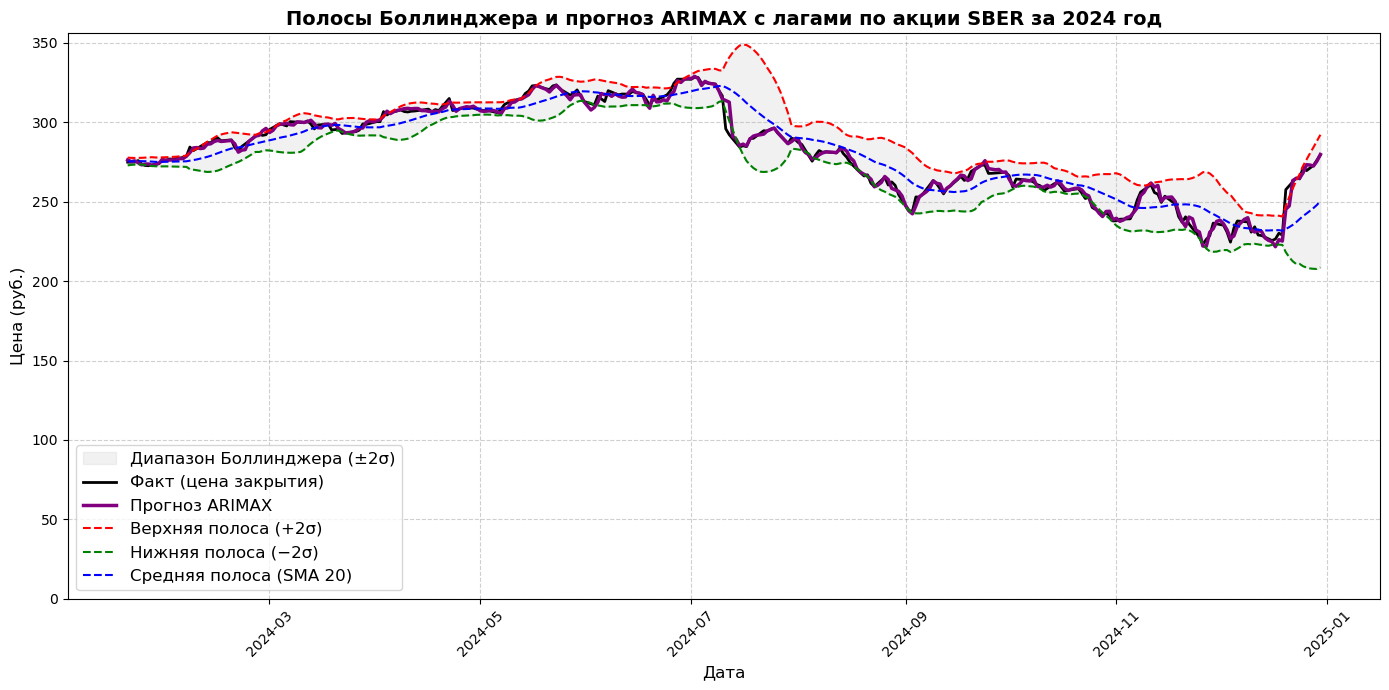

In [18]:
# === Полосы Боллинджера и прогноз ARIMAX с лагами (2024 год) ===

# Отбор данных за 2024 год
df_boll = df.loc["2024-01-01":"2024-12-31"].copy()
df_boll["close"] = df_boll["Stock Close"]

# Расчёт полос Боллинджера
df_boll["bollinger_mid"] = df_boll["close"].rolling(window=20).mean()
df_boll["bollinger_std"] = df_boll["close"].rolling(window=20).std()
df_boll["bollinger_upper"] = df_boll["bollinger_mid"] + 2 * df_boll["bollinger_std"]
df_boll["bollinger_lower"] = df_boll["bollinger_mid"] - 2 * df_boll["bollinger_std"]
df_boll.dropna(subset=["bollinger_upper", "bollinger_lower"], inplace=True)

# Прогноз ARIMAX как Series
forecast_series = forecast_df["Forecast Stock Close"]

# Общий индекс для визуализации
common_index = df_boll.index.intersection(forecast_series.index)

# Подготовка данных
forecast_for_boll = forecast_series.loc[common_index]
actual_for_boll = forecast_df["Actual Stock Close"].loc[common_index]
upper = df_boll["bollinger_upper"].loc[common_index]
lower = df_boll["bollinger_lower"].loc[common_index]
mid = df_boll["bollinger_mid"].loc[common_index]

# === Визуализация ===
plt.figure(figsize=(14, 7))

# Диапазон Боллинджера
plt.fill_between(common_index, lower, upper, color="lightgray", alpha=0.3, label="Диапазон Боллинджера (±2σ)")

# Фактическая цена
plt.plot(actual_for_boll.index, actual_for_boll, label="Факт (цена закрытия)", color="black", linewidth=2)

# Прогноз ARIMAX
plt.plot(forecast_for_boll.index, forecast_for_boll, label="Прогноз ARIMAX", color="purple", linewidth=2.5)

# Полосы
plt.plot(upper.index, upper, label="Верхняя полоса (+2σ)", color="red", linestyle="--", linewidth=1.5)
plt.plot(lower.index, lower, label="Нижняя полоса (−2σ)", color="green", linestyle="--", linewidth=1.5)
plt.plot(mid.index, mid, label="Средняя полоса (SMA 20)", color="blue", linestyle="--", linewidth=1.5)

# Оформление
plt.title("Полосы Боллинджера и прогноз ARIMAX с лагами по акции SBER за 2024 год", fontsize=14, fontweight="bold")
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Цена (руб.)", fontsize=12)
plt.ylim(bottom=0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
